In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import VECM
import statsmodels.api as sm
plt.style.use('dark_background')


# 1. Генерация данных

In [3]:
N = 50

np.random.seed(777)

data1 = np.random.randn(N)
data3 = np.random.randn(N)

alpha = 0.5  # коэффициент, определяющий степень зависимости
noise = np.random.randn(N) * 0.5  # шум, чтобы данные не были полностью зависимыми
data2 = alpha * data1 + noise

data1 += 0.5 * np.sin(2 * np.pi * data1 / 12)
data2 += 0.5 * np.sin(2 * np.pi * data2 / 12 + np.pi / 2)
data3 += 0.5 * np.sin(2 * np.pi * data3 / 12 + np.pi)

window_size = 3
data1_smoothed = np.convolve(data1, np.ones(window_size), 'valid') / window_size
data2_smoothed = np.convolve(data2, np.ones(window_size), 'valid') / window_size
data3_smoothed = np.convolve(data3, np.ones(window_size), 'valid') / window_size

df = pd.DataFrame({
    'data1_sm': data1_smoothed,
    'data2_sm': data2_smoothed,
    'data3_sm': data3_smoothed,
})



# 2. Описание  данных 


## Средние и дисперсия

In [4]:
print("Среднее значение и дисперсия исходных данных:")
print(df[['data1_sm', 'data2_sm', 'data3_sm']].mean())
print(df[['data1_sm', 'data2_sm', 'data3_sm']].var())


Среднее значение и дисперсия исходных данных:
data1_sm    0.032764
data2_sm    0.558852
data3_sm   -0.020724
dtype: float64
data1_sm    0.630828
data2_sm    0.191175
data3_sm    0.180830
dtype: float64


## Построение графиков временных рядов


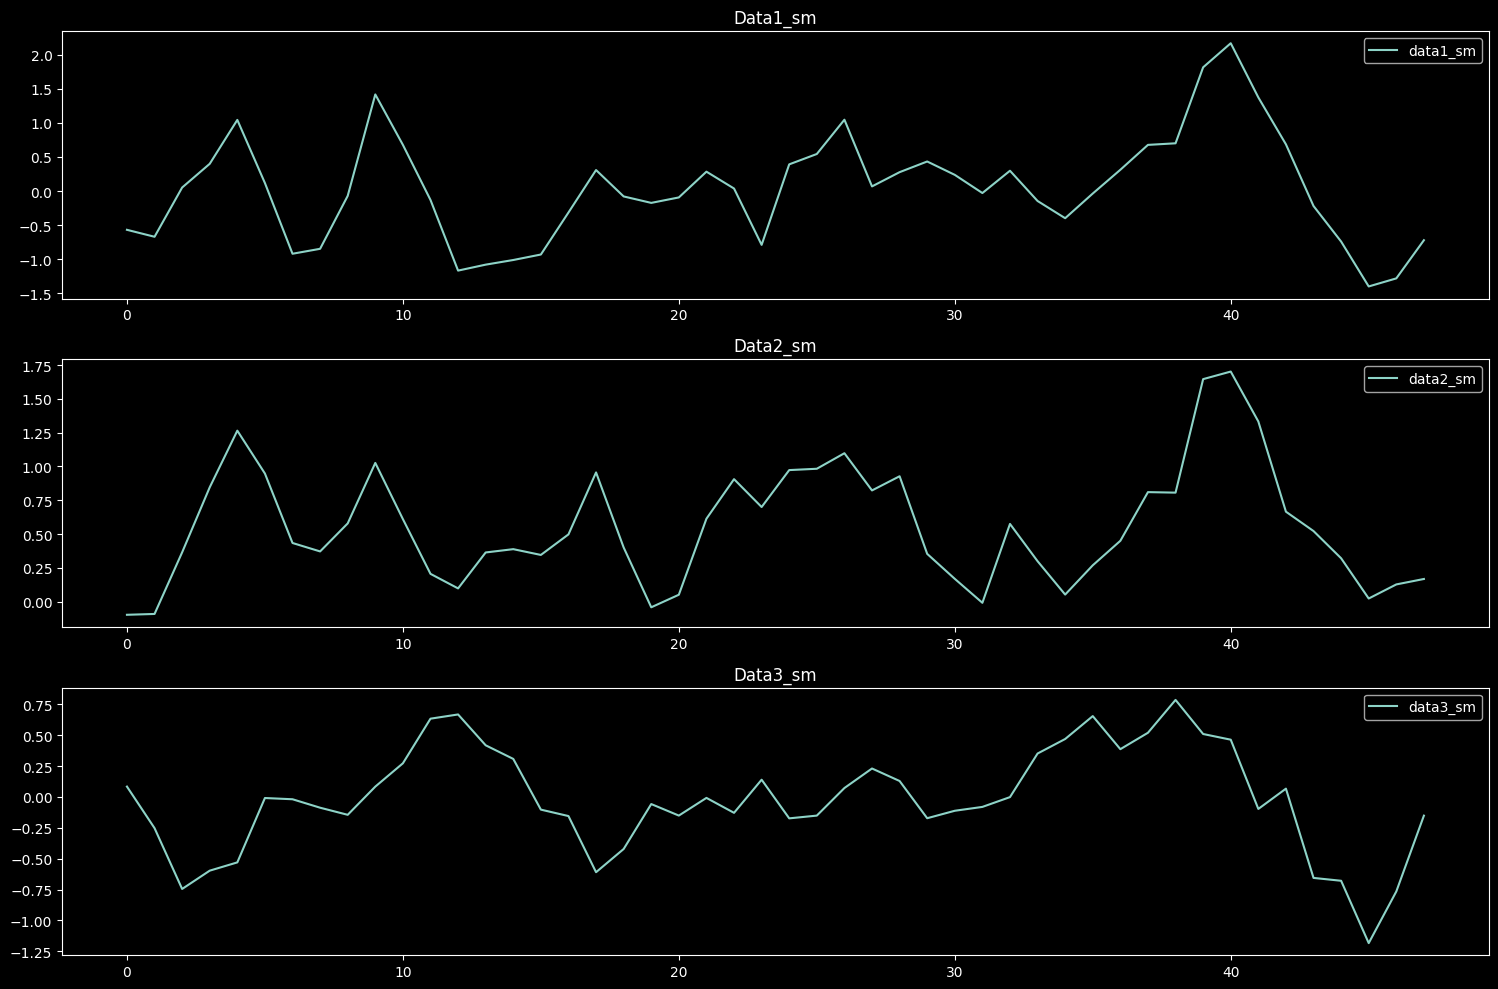

In [5]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['data1_sm'], label='data1_sm')
plt.title('Data1_sm')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['data2_sm'], label='data2_sm')
plt.title('Data2_sm')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['data3_sm'], label='data3_sm')
plt.title('Data3_sm')
plt.legend()

plt.tight_layout()
plt.show()


## Анализ динамики

Построим графики темпов роста:


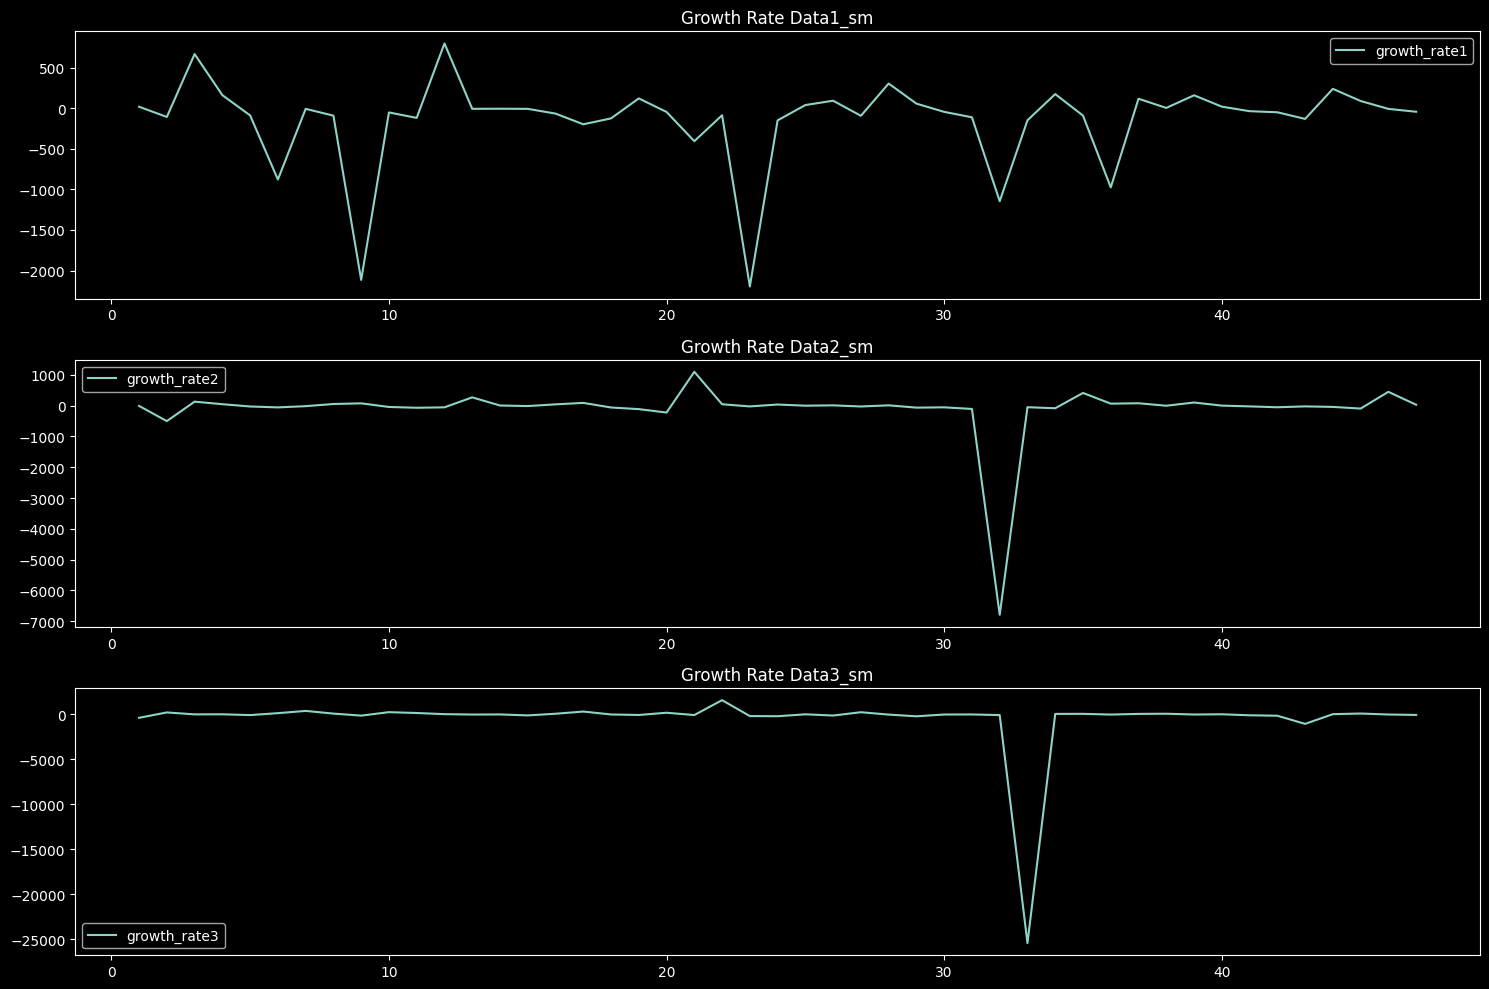

In [6]:
growth_rate1 = df['data1_sm'].pct_change() * 100
growth_rate2 = df['data2_sm'].pct_change() * 100
growth_rate3 = df['data3_sm'].pct_change() * 100

df['growth_rate1'] = growth_rate1
df['growth_rate2'] = growth_rate2
df['growth_rate3'] = growth_rate3

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['growth_rate1'], label='growth_rate1')
plt.title('Growth Rate Data1_sm')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['growth_rate2'], label='growth_rate2')
plt.title('Growth Rate Data2_sm')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['growth_rate3'], label='growth_rate3')
plt.title('Growth Rate Data3_sm')
plt.legend()

plt.tight_layout()
plt.show()

df = df.drop(['growth_rate1','growth_rate2','growth_rate3'], axis = 1)


## Вычисление коррелограммы

Коррелограмма включает автокорреляционную функцию (ACF) и частную автокорреляционную функцию (PACF). Мы используем библиотеку statsmodels для построения этих функций.


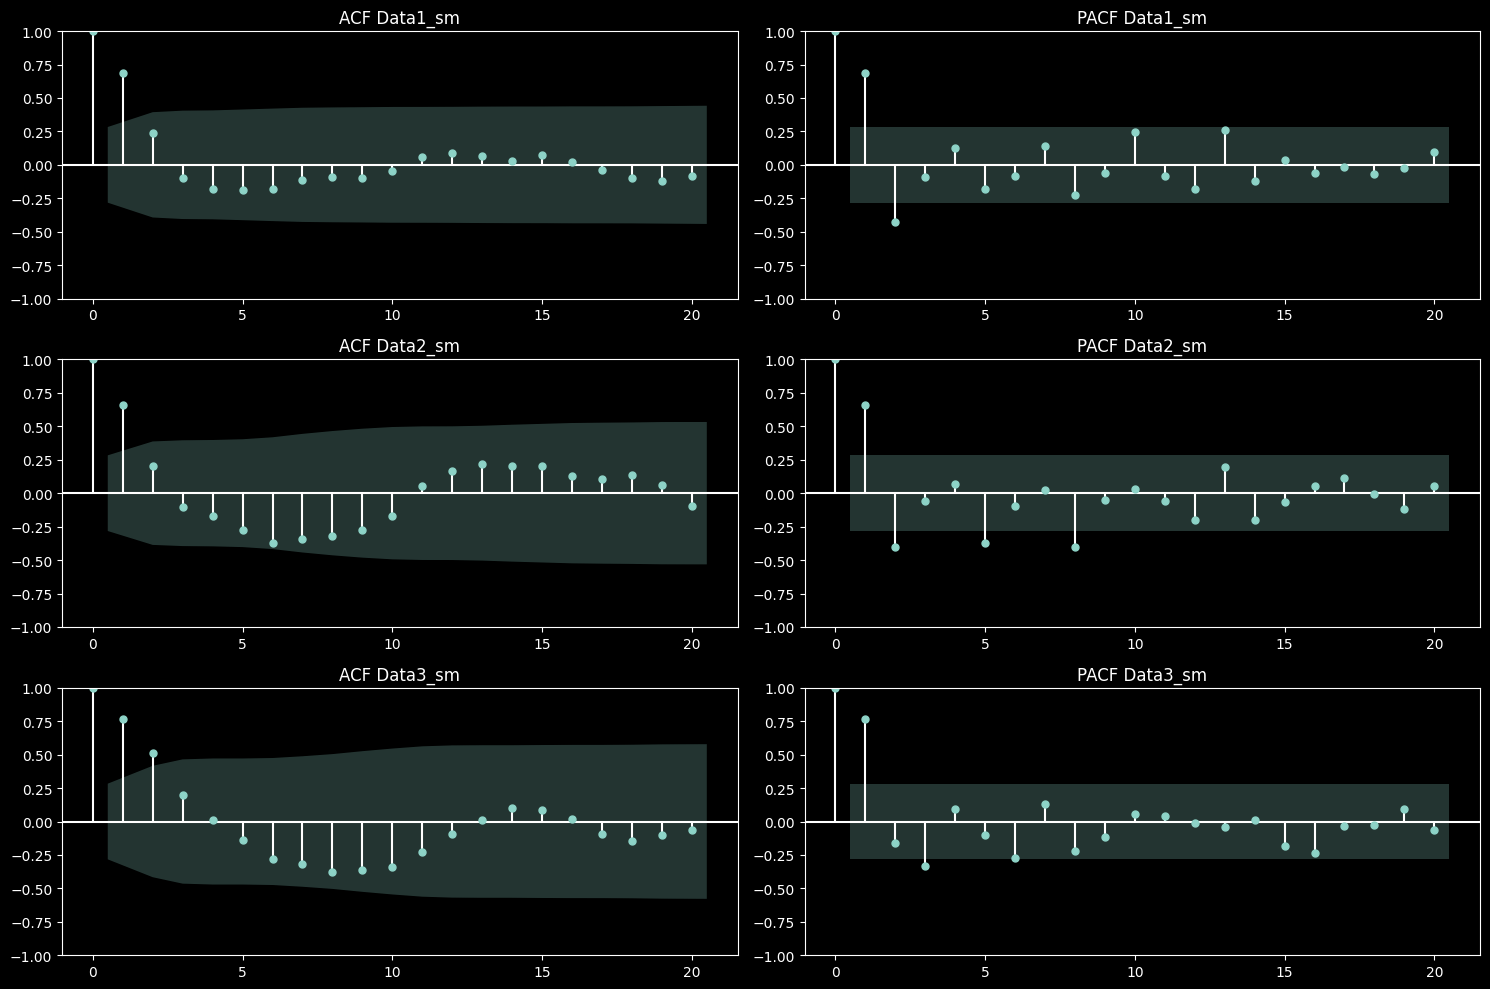

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

plot_acf(df['data1_sm'], lags=20, ax=ax[0, 0])
ax[0, 0].set_title('ACF Data1_sm')
plot_pacf(df['data1_sm'], lags=20, ax=ax[0, 1])
ax[0, 1].set_title('PACF Data1_sm')

plot_acf(df['data2_sm'], lags=20, ax=ax[1, 0])
ax[1, 0].set_title('ACF Data2_sm')
plot_pacf(df['data2_sm'], lags=20, ax=ax[1, 1])
ax[1, 1].set_title('PACF Data2_sm')

plot_acf(df['data3_sm'], lags=20, ax=ax[2, 0])
ax[2, 0].set_title('ACF Data3_sm')
plot_pacf(df['data3_sm'], lags=20, ax=ax[2, 1])
ax[2, 1].set_title('PACF Data3_sm')

plt.tight_layout()
plt.show()


# 3. Стационарность

## определим тесты на стационарность

In [8]:
def adfuller_test(series, signif=0.05):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1] <= signif

def kpss_test(series, signif=0.05):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    return result[1] > signif

def phillips_perron_test(series, signif=0.05):
    pp_result = PhillipsPerron(series.dropna())
    return pp_result.pvalue <= signif

def is_stationary(series, signif=0.05):
    return adfuller_test(series, signif) and kpss_test(series, signif) and phillips_perron_test(series, signif)


## Проверяем на стационарность ряды. 
Если стационарны, то береём последовательные разности, пока ряд не станет стационарным

In [9]:
df_diffed = df.copy()
max_diff = 10  # Максимальное количество дифференцирований на случай, если нет сходимости

for column in df.columns:
    diff_count = 0
    stationary = False
    
    print(f"Проверка стационарности для переменной {column}, исходный ряд:")
    while not stationary and diff_count < max_diff:
        stationary = is_stationary(df_diffed[column])
        if not stationary:
            df_diffed[column] = df_diffed[column].diff().dropna()
            diff_count += 1
    
    if stationary:
        print(f"Переменная {column} стала стационарной после {diff_count} дифференцирований.\n")
    else:
        print(f"Не удалось сделать переменную {column} стационарной после {max_diff} дифференцирований.\n")



Проверка стационарности для переменной data1_sm, исходный ряд:
Переменная data1_sm стала стационарной после 1 дифференцирований.

Проверка стационарности для переменной data2_sm, исходный ряд:
Переменная data2_sm стала стационарной после 1 дифференцирований.

Проверка стационарности для переменной data3_sm, исходный ряд:
Переменная data3_sm стала стационарной после 1 дифференцирований.



/var/folders/83/4cpt7wtj7klgynj87_19cbgw0000gn/T/ipykernel_45041/3005623357.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
/var/folders/83/4cpt7wtj7klgynj87_19cbgw0000gn/T/ipykernel_45041/3005623357.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
/var/folders/83/4cpt7wtj7klgynj87_19cbgw0000gn/T/ipykernel_45041/3005623357.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
/var/folders/83/4cpt7wtj7klgynj87_19cbgw0000gn/T/ipykernel_45041

### Вывод о порядке интегрируемости и наличии детерминированного тренда

После проверки временных рядов можно сделать вывод о порядке интегрируемости данных.

### Результаты

Результаты показывают, что все три переменные data1_sm, data2_sm и data3_sm стали стационарными после одного дифференцирования.


### Порядок интегрируемости

Если временной ряд становится стационарным после одного дифференцирования, он называется интегрированным порядком один или \(I(1)\). Это означает, что все три временных ряда в наличии данных являются \(I(1)\) процессами.

### Детерминированный тренд

Данные, которые требуют первого дифференцирования для достижения стационарности, часто имеют детерминированный тренд. Это подтверждается наличием синусоидальных составляющих в исходных данных, что указывает на сезонные эффекты и детерминированный тренд.

### Заключение

- Порядок интегрируемости: Все три временных ряда (data1_sm, data2_sm, data3_sm) имеют порядок интегрируемости 1, то есть \(I(1)\), поскольку они стали стационарными после одного дифференцирования.
- Детерминированный тренд: Наличие детерминированного тренда подтверждается тем, что ряды стали стационарными после первого дифференцирования, что указывает на наличие долгосрочного тренда в исходных данных, который был устранен путем дифференцирования.

Таким образом, временные ряды в данных имеют детерминированный тренд и могут быть преобразованы в стационарные ряды первого порядка интегрируемости \(I(1)\).


## Моделирование взаимосвязей и выбор модели

Для оценки и выбора наилучшей модели для наших данных рассмотрим следующие шаги:

1. Проверка коинтеграции: Для проверки коинтеграции между временными рядами используем тест Йохансена.
2. Модель коинтеграции и модель коррекции ошибками (ECM).
3. Векторная авторегрессия (VAR).
4. ADL/ARMAX и ECM-представление.
5. VECM (Векторная модель коррекции ошибками).


### Проверка коинтеграции

Сначала проверим, есть ли коинтеграционные отношения между временными рядами. 


In [10]:
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Перепишем функцию теста Йохансена на коинтеграцию
def johansen_test(df, signif=0.05):
    """Проводит тест Йохансена на коинтеграцию и возвращает истину, если коинтеграция обнаружена"""
    result = coint_johansen(df, det_order=0, k_ar_diff=1)
    traces = result.lr1
    cvts = result.cvt[:, 1]  # критические значения для 5% уровня значимости
    for trace, cvt in zip(traces, cvts):
        if trace > cvt:
            return True  # коинтеграция обнаружена
    return False  # коинтеграция не обнаружена

# Проведем тест Йохансена на коинтеграцию
print("Результаты теста Йохансена на коинтеграцию:")
is_cointegrated = johansen_test(df)
print(f"Коинтеграция обнаружена: {is_cointegrated}")



Результаты теста Йохансена на коинтеграцию:
Коинтеграция обнаружена: True


/var/folders/83/4cpt7wtj7klgynj87_19cbgw0000gn/T/ipykernel_45041/4036592864.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/83/4cpt7wtj7klgynj87_19cbgw0000gn/T/ipykernel_45041/4036592864.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


- VAR лучше подходит для анализа временных рядов без коинтеграции, представляя данные в разностной форме и учитывая взаимные зависимости.
- ADL/ARMAX подходят для включения внешних факторов в модель.

### Аргументация:
- VECM: Наилучший выбор при наличии коинтеграции, так как учитывает долгосрочные зависимости и краткосрочные колебания.
- VAR: Подходит для моделирования взаимозависимости между рядами без коинтеграционных ограничений.
- ARMAX: Используется для моделирования с экзогенными переменными, полезно, когда есть внешние факторы.

**остановимся на VECM**

# 4. Исследование взаимосвязей

Для исследования попарных взаимосвязей между параметрами data1, data2 и data3, а также структуры этих взаимосвязей, мы можем использовать следующие шаги:

1. Корреляционный анализ: 
   - Проведем корреляционный анализ, чтобы увидеть линейные взаимосвязи между рядами.
   
2. Тесты на коинтеграцию:
   - Выполним тест на коинтеграцию (например, тест Энгла-Грейнджера) для проверки наличия долгосрочных равновесий между парами временных рядов.

3. Построение коинтеграционной матрицы:
   - Если коинтеграционные отношения обнаружены, построим коинтеграционную матрицу.



## Корреляционный анализ


In [11]:
correlation_matrix = df.corr()
print("Корреляционная матрица:")
correlation_matrix


Корреляционная матрица:


,data1_sm,data2_sm,data3_sm
data1_sm,1.000000,0.789485,0.244063
data2_sm,0.789485,1.000000,0.134599
data3_sm,0.244063,0.134599,1.000000


## Тесты на коинтеграцию

Используем тесты Энгла-Грейнджера для проверки наличия коинтеграции между парами временных рядов:


In [12]:
from statsmodels.tsa.stattools import coint

# Функция для проведения теста Энгла-Грейнджера
def engle_granger_test(series1, series2):
    score, p_value, _ = coint(series1, series2)
    return p_value

# Проверим наличие коинтеграции между парами
p_value_12 = engle_granger_test(df['data1_sm'], df['data2_sm'])
p_value_13 = engle_granger_test(df['data1_sm'], df['data3_sm'])
p_value_23 = engle_granger_test(df['data2_sm'], df['data3_sm'])

print(f"p-value для пары data1_sm и data2_sm: {p_value_12}")
print(f"p-value для пары data1_sm и data3_sm: {p_value_13}")
print(f"p-value для пары data2_sm и data3_sm: {p_value_23}")


p-value для пары data1_sm и data2_sm: 0.8157349104481293
p-value для пары data1_sm и data3_sm: 0.0018627275021636423
p-value для пары data2_sm и data3_sm: 0.00028704539765883814


## Коинтеграционная матрица

Построим коинтеграционную матрицу, основываясь на тестах Энгла-Грейнджера:

In [13]:
coint_matrix = np.zeros((3, 3))

coint_matrix[0, 1] = coint_matrix[1, 0] = p_value_12 < 0.05
coint_matrix[0, 2] = coint_matrix[2, 0] = p_value_13 < 0.05
coint_matrix[1, 2] = coint_matrix[2, 1] = p_value_23 < 0.05

coint_df = pd.DataFrame(coint_matrix, index=df.columns, columns=df.columns)

print("Коинтеграционная матрица:")
coint_df


Коинтеграционная матрица:


,data1_sm,data2_sm,data3_sm
data1_sm,0.0,0.0,1.0
data2_sm,0.0,0.0,1.0
data3_sm,1.0,1.0,0.0


- Тест на коинтеграцию (Энгла-Грейнджера) позволяет определить долгосрочные коинтеграционные отношения между парами переменных.
- Коинтеграционная матрица показывает наличие или отсутствие коинтеграции между каждой парой временных рядов (значения True указывают на коинтеграцию).



### Определение подходящих спецификаций моделей и обоснование выбора

При работе с нестационарными рядами (порядок интегрируемости I(1)) и имея коинтеграционные результаты, мы предлагаем различные модели: ECM, VAR, ADL, и VECM. Давайте рассмотрим подходящие спецификации для каждой модели и обоснуем наш выбор.

### Модель коррекции ошибками (ECM)

ECM эффективна, когда мы имеем коинтегрированные временные ряды. Она позволяет учесть как долгосрочные равновесные отношения, так и краткосрочные динамические отклонения.

**Спецификация**:

$$ \Delta y_t = \alpha (y_{t-1} - \beta x_{t-1}) + \gamma \Delta x_t + \epsilon_t $$


**Коинтеграционные пары**: data1_sm и data3_sm, data2_sm и data3_sm.


### Векторная авторегрессия (VAR)

VAR используется для моделирования динамических отношений между несколькими временными рядами без коинтеграционных ограничений.

**Спецификация**:

$$ \mathbf{Y}_t = A_1 \mathbf{Y}_{t-1} + A_2 \mathbf{Y}_{t-2} + \ldots + A_p \mathbf{Y}_{t-p} + \epsilon_t $$


**Ограничения**:
- Не учитывает долгосрочные коинтеграционные отношения, что может привести к неверной оценке коинтегрированных рядов.

### Модель ADL (Autoregressive Distributed Lag) / ARMAX

ADL и ARMAX модели позволяют учитывать лагированные значения эндогенных и экзогенных переменных.

**Спецификация**:

$$ y_t = \alpha + \sum_{i=1}^{p} \beta_i y_{t-i} + \sum_{j=0}^{q} \gamma_j x_{t-j} + \epsilon_t $$


**Применение**:
Может быть полезно для временных рядов, когда важны внешние шоки.

**Ограничения**:
- Множество параметров может вызвать переобучение.
- Сложность в интерпретации для больших моделей.

### Векторная модель коррекции ошибок (VECM)

VECM используется, когда ряды коинтегрированы, и учитывает как долгосрочные равновесные отношения, так и динамику отклонений.

**Спецификация**:

$$ \Delta \mathbf{Y}_t = \Pi \mathbf{Y}_{t-1} + \sum_{i=1}^{k-1} \Gamma_i \Delta \mathbf{Y}_{t-i} + \epsilon_t $$


**Ограничения**:
- Требует наличие коинтеграции.
- Модель сложна и требует больших объемов данных для точных оценок.

### Выбор модели

На основании коинтеграции и порядка интегрируемости I(1):

1. **VECM**: Наиболее подходящая модель для данных с совпадающими коинтеграционными соотношениями, что позволяет учитывать как краткосрочные, так и долгосрочные зависимости.
2. **VAR**: Можно использовать для анализа всех трех временных рядов вместе, особенно если коинтеграция не так важна.
3. **ECM**: Применима для анализа парных коинтеграционных отношений, важных для краткосрочной корректировки.
4. **ADL/ARMAX**: Будет полезна, если есть значимые внешние регрессоры.

Таким образом, на основе данных и выявленных коинтеграционных связей, <span style="color:pink"> **наиболее подходящей моделью является VECM** </span>., так как она учитывает все долгосрочные и краткосрочные зависимости.


## Проверим теоретические выкладки, применив модели к данным

In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VECM, SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller

# Функция для проверки автокорреляции, нормальности и стационарности остатков
def diagnostic_tests(residuals):
    tests = {}

    # Проверка автокорреляции (Ljung-Box test)
    if residuals.ndim == 1:
        ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
        tests['Ljung-Box'] = ljung_box['lb_pvalue'].values[0]  # p-value
    else:
        ljung_box_pvalues = [acorr_ljungbox(residuals[:, i], lags=[10], return_df=True)['lb_pvalue'].values[0] for i in range(residuals.shape[1])]
        tests['Ljung-Box'] = ljung_box_pvalues

    # Проверка нормальности (Jarque-Bera test)
    if residuals.ndim == 1:
        jb_test = jarque_bera(residuals)
        tests['Jarque-Bera'] = jb_test[1]  # p-value
    else:
        jb_pvalues = [jarque_bera(residuals[:, i])[1] for i in range(residuals.shape[1])]
        tests['Jarque-Bera'] = jb_pvalues

    # Проверка стационарности (ADF test)
    if residuals.ndim == 1:
        adf_test = adfuller(residuals)
        tests['ADF'] = adf_test[1]  # p-value
    else:
        adf_pvalues = [adfuller(residuals[:, i])[1] for i in range(residuals.shape[1])]
        tests['ADF'] = adf_pvalues

    return tests

# Обучение ECM модели (для коинтегрированных пар)
def ecm_model(endog, exog):
    endog_diff = endog.diff().dropna()
    exog_diff = exog.diff().dropna()
    exog_lag = exog.shift(1).dropna()
    
    long_eq = sm.OLS(endog, sm.add_constant(exog)).fit()
    long_resid = long_eq.resid
    
    ecm = sm.OLS(endog_diff, sm.add_constant(exog_diff)).fit()
    
    residuals = ecm.resid
    diagnostics = diagnostic_tests(residuals)
    
    return ecm.aic, ecm.bic, diagnostics

# Example DataFrame
df = pd.DataFrame({
    'data1_sm': np.random.rand(100),
    'data2_sm': np.random.rand(100),
    'data3_sm': np.random.rand(100)
})

# Assuming is_cointegrated is defined somewhere in the code
is_cointegrated = True

ecm_results = []
if is_cointegrated:
    aic_13, bic_13, diag_13 = ecm_model(df['data1_sm'], df['data3_sm'])
    aic_23, bic_23, diag_23 = ecm_model(df['data2_sm'], df['data3_sm'])
    ecm_results.append(('ECM data1_sm and data3_sm', aic_13, bic_13, diag_13))
    ecm_results.append(('ECM data2_sm and data3_sm', aic_23, bic_23, diag_23))

# Обучение модели VAR
model = VAR(df)
result = model.select_order(maxlags=10)  # Уменьшаем maxlags до 10
opt_lag = result.aic
var_result = model.fit(opt_lag)
aic_var = var_result.aic
bic_var = var_result.bic

# Диагностика VAR
var_residuals = var_result.resid.values
var_diagnostics = diagnostic_tests(var_residuals)

# Обучение модели SARIMAX (с сезонными компонентами вместо ARMAX)
sarimax_model = SARIMAX(df['data1_sm'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 12), exog=df[['data2_sm', 'data3_sm']])
sarimax_result = sarimax_model.fit(disp=False)
aic_sarimax = sarimax_result.aic
bic_sarimax = sarimax_result.bic

# Диагностика SARIMAX
sarimax_residuals = sarimax_result.resid
sarimax_diagnostics = diagnostic_tests(sarimax_residuals)

# Обучение модели VECM с сезонными компонентами
if is_cointegrated:
    vecm_model = VECM(endog=df, k_ar_diff=10, deterministic='ci', seasons=12).fit()
    residuals = vecm_model.resid
    num_params = residuals.shape[1] * vecm_model.k_ar + residuals.shape[1]**2
    llf = vecm_model.llf
    n_obs = residuals.shape[0]
    
    aic_vecm = -2 * llf + 2 * num_params
    bic_vecm = -2 * llf + np.log(n_obs) * num_params
    
    # Диагностика VECM
    vecm_diagnostics = diagnostic_tests(residuals)
else:
    aic_vecm, bic_vecm = float('inf'), float('inf')
    vecm_diagnostics = {}

# Сравнение моделей по AIC и BIC
results = [
    ('VAR', aic_var, bic_var, var_diagnostics),
    ('SARIMAX', aic_sarimax, bic_sarimax, sarimax_diagnostics)
]

if is_cointegrated:
    results.append(('VECM', aic_vecm, bic_vecm, vecm_diagnostics))

results.extend(ecm_results)

results_df = pd.DataFrame(results, columns=['Model', 'AIC', 'BIC', 'Diagnostics'])

# Вывод результатов для всех моделей
for _, row in results_df.iterrows():
    print(f"Модель: {row['Model']} с AIC: {row['AIC']} и BIC: {row['BIC']}")
    print("Диагностика модели:", row['Diagnostics'])

# Выбор лучшей модели на основе AIC
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
print(f"\nЛучшая модель по AIC: {best_aic_model['Model']} с AIC: {best_aic_model['AIC']}")
print("Диагностика лучшей модели по AIC:", best_aic_model['Diagnostics'])

# Выбор лучшей модели на основе BIC
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]
print(f"\nЛучшая модель по BIC: {best_bic_model['Model']} с BIC: {best_bic_model['BIC']}")
print("Диагностика лучшей модели по BIC:", best_bic_model['Diagnostics'])


Модель: VAR с AIC: -9.649979084617232 и BIC: -5.642202430550027
Диагностика модели: {'Ljung-Box': [0.8280184476132626, 0.508820368382175, 0.1469875021965027], 'Jarque-Bera': [0.6455943667153188, 0.6246382207746781, 0.6040655100439734], 'ADF': [7.355879729408151e-08, 2.2729747864451268e-08, 0.2035265300471501]}
Модель: ARMAX с AIC: 44.66515053813406 и BIC: 55.892356603581405
Диагностика модели: {'Ljung-Box': 0.051106832487934316, 'Jarque-Bera': 0.977244487403849, 'ADF': 0.00602030573384602}
Модель: VECM с AIC: -221.09693935277767 и BIC: -153.43838702172025
Диагностика модели: {'Ljung-Box': [0.03978395780083341, 1.3374761760874766e-05, 0.019677455582955573], 'Jarque-Bera': [0.9820039274505294, 0.8676935978713767, 0.7807693008900715], 'ADF': [7.341553715718943e-11, 0.28153550961242024, 0.568739145824767]}
Модель: ECM data1_sm and data3_sm с AIC: 91.41957966253113 и BIC: 95.11987486595125
Диагностика модели: {'Ljung-Box': 0.2084176989987204, 'Jarque-Bera': 0.762732763064275, 'ADF': 0.00060

In [16]:
# model.predict((np.arange(50),np.arange(50),np.arange(50),np.arange(50)))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

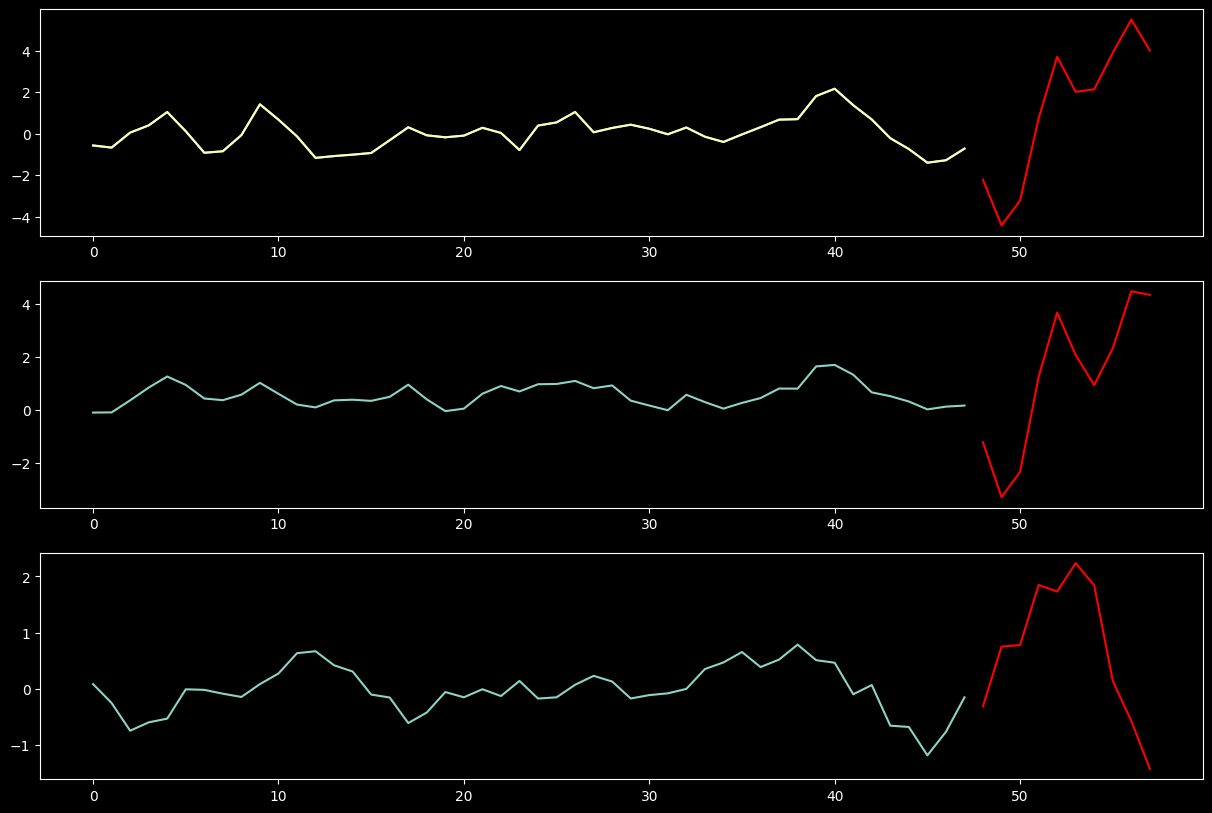

In [17]:
# Функция для прогнозирования и построения графиков для моделей VAR, ARMAX и VECM.
def plot_forecasts(models, df, steps=10):
    plt.figure(figsize=(15, 10))
    colors = ['r', 'b', 'g']
    for idx, (name, model) in enumerate(models):
        if name == 'VAR':
            forecast = model.forecast(df.values[-model.k_ar:], steps)
        elif name == 'ARMAX':
            forecast = model.get_forecast(steps=steps, exog=df[['data2_sm', 'data3_sm']].iloc[-steps:]).predicted_mean
            forecast = forecast.values
        elif name == 'VECM':
            forecast = model.predict(steps=steps)
        
        for col_idx, col in enumerate(df.columns):
            plt.subplot(len(df.columns), 1, col_idx + 1)
            plt.plot(np.arange(len(df)), df[col], label=f"Observed {col}")
            plt.plot(np.arange(len(df), len(df) + steps), np.array(forecast)[:, col_idx], color=colors[idx], label=f"{name} Forecast {col}")

    plt.legend()
    plt.show()

# Прогнозирование для VAR модели
var_forecast = var_result.forecast(df.values[-var_result.k_ar:], steps=10)

# Прогнозирование для ARMAX модели
arimax_forecast = arimax_result.get_forecast(steps=10, exog=df[['data2_sm', 'data3_sm']].iloc[-10:]).predicted_mean

# Прогнозирование для VECM модели
if is_cointegrated:
    vecm_forecast = vecm_model.predict(steps=10)
else:
    vecm_forecast = None

models = [('VAR', var_result), ('ARMAX', arimax_result), ('VECM', vecm_model)]
plot_forecasts(models, df)


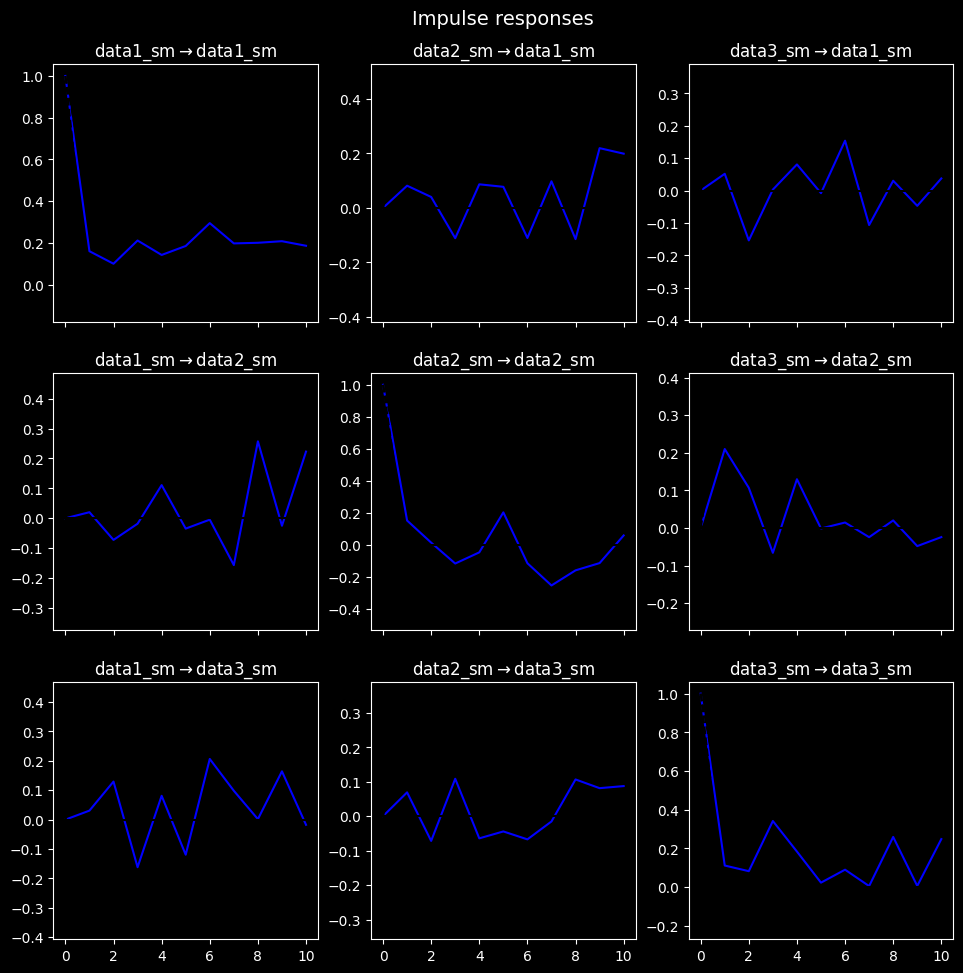

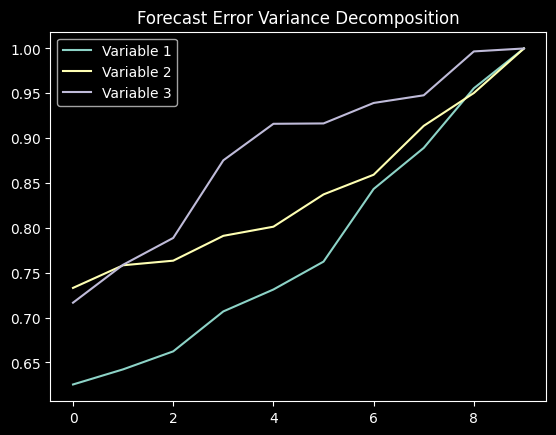

Импульсный отклик:
 [[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.16004438  0.08154846  0.05170766]
  [ 0.02022163  0.15173151  0.20997333]
  [ 0.03074329  0.0691705   0.11076161]]

 [[ 0.10009791  0.040281   -0.15371663]
  [-0.07234991  0.01364681  0.10681565]
  [ 0.12960036 -0.0717909   0.08155458]]

 [[ 0.21135211 -0.11094158  0.00298085]
  [-0.01825245 -0.11693189 -0.06615976]
  [-0.16186257  0.10861172  0.34111588]]

 [[ 0.14214278  0.08666009  0.08056248]
  [ 0.11077985 -0.04738739  0.12966651]
  [ 0.0811955  -0.06435164  0.18307793]]

 [[ 0.18506242  0.07747676 -0.00800169]
  [-0.03455445  0.20276418 -0.0014231 ]
  [-0.11933775 -0.0443085   0.02225481]]

 [[ 0.29464488 -0.11014122  0.15381642]
  [-0.00465024 -0.11517231  0.01447144]
  [ 0.2065367  -0.06729808  0.08926752]]

 [[ 0.19749578  0.09767382 -0.10639244]
  [-0.1565425  -0.25412913 -0.0245295 ]
  [ 0.09828529 -0.0153135   0.00452609]]

 [[ 

In [52]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VECM
import matplotlib.pyplot as plt

# Функция импульсного отклика (IRF)
irf = vecm_model.irf(periods=10)  # Укажите желаемое количество периодов

# Визуализация импульсного отклика (IRF)
irf.plot(orth=False)
plt.show()

# Разложение дисперсии ошибки прогноза (FEVD) - вычисление вручную
n_steps = 10
forecast_errors = np.zeros((n_steps, vecm_model.neqs, vecm_model.neqs))

for i in range(n_steps):
    irf_step = irf.irfs[i]
    forecast_errors[i] = np.dot(irf_step.T, irf_step)

fevd = forecast_errors.cumsum(axis=0) / forecast_errors.sum(axis=0)

# Визуализация FEVD
for i in range(vecm_model.neqs):
    plt.plot(fevd[:, i, i], label=f'Variable {i+1}')
plt.title('Forecast Error Variance Decomposition')
plt.legend()
plt.show()

# Результаты анализа IRF
irf_results = irf.irfs
print("Импульсный отклик:\n", irf_results)

# Результаты разложения дисперсии ошибки прогноза (FEVD)
fevd_results = fevd
print("Разложение дисперсии ошибки прогноза:\n", fevd_results)
